Debugging the Evaluation finetuning method

We want to explore if there is any problems in this component of the ESSL algorithm. 

In [1]:
from essl.evaluate_downstream import finetune
from essl.backbones import ResNet18_backbone, tinyCNN_backbone
from essl.datasets import Cifar10
import matplotlib.pyplot as plt

/home/noah/.conda/envs/ESSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Components of finetuning:

To finetune a model, first we give the algorithm a pretrained backbone. GIven the backbone, a new model is created with a linear layer with N input units and M output units, where N is the number of classes in the problem.

In order to connect the backbone and the classifier, the backbone is simply flattened. 

Investigating tinyCNN with cifar10, first we are interested to see if we can train a simple model with cifar10 and the tinyCNN architecture. 

The tinyCNN takes a 3 channel input (RGB), and performs a convolution on it using a kernel size of 5x5 with a stride of 1,1 resulting in 6 channels, it is then passed to a relu and then a maxpool with a kernel size of 2 and stride of 2 is used, no dilation is used. This is then repeated, but now the channel size is bumped up from 6 to 16 using a kernel size of 5,5 and stride of 1,1. 

Finetuning task:
performing the finetuning task, there are 5 different components to adjust
* dataset
* optimizer type
* number of epochs
* loss
* batch_size

For this experiment, we use Adam with a lr of 3e-4, and all other default parameters, the batch size is set to 32, number of epocsh is 10 and loss is crossentropy loss

In [2]:
cifar10 = Cifar10(split_seed=10)
ft = finetune(cifar10, verbose=True)
ft_100e = finetune(cifar10, num_epochs=100, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Training for 10 epochs

tinyCNN_backbone(
  (backbone): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


100%|███████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


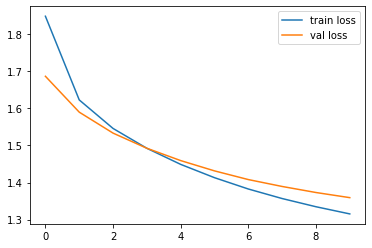

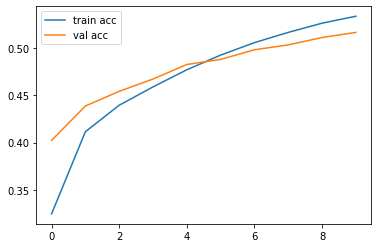

final test accuracy:  0.5629
final train accuracy:  0.5339333333333334
final val accuracy:  0.5168


<Figure size 432x288 with 0 Axes>

In [3]:
# finetune model
tc_backbone = tinyCNN_backbone()
print(tc_backbone)
train_losses, train_accs, val_losses, val_accs, test_acc = ft(tc_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])


The resultant classifier is not very strong, but this not surprising as it is very small and only trained for 10 epochs. We will try to train for more epochs to see if accuracy can be improved. We want to overfit the training set first to ensure that the pipeline is actually working properly. 

Training for 100 epochs

100%|█████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.92s/it]


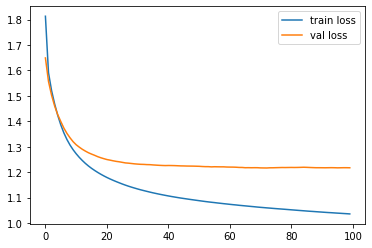

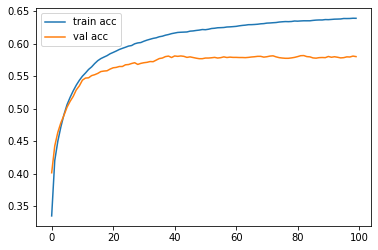

final test accuracy:  0.6291
final train accuracy:  0.6388888888888888
final val accuracy:  0.58


<Figure size 432x288 with 0 Axes>

In [4]:
# finetune model
tc_backbone = tinyCNN_backbone()
train_losses, train_accs, val_losses, val_accs, test_acc = ft_100e(tc_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()


print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])

Training ResNet18:
* we expect that the resnet 18 should perform much better

training for 10 epochs:

ResNet18_backbone(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

100%|███████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.43s/it]


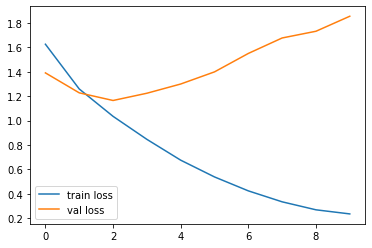

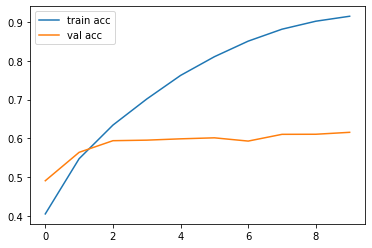

final test accuracy:  0.6589
final train accuracy:  0.9147555555555555
final val accuracy:  0.6156


<Figure size 432x288 with 0 Axes>

In [5]:
# finetune model
rn_backbone = ResNet18_backbone()
print(rn_backbone)
train_losses, train_accs, val_losses, val_accs, test_acc = ft(rn_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])

With the resnet18 form 10 epochs we see better results... 0.71 testing accuracy, it is important to note that this is pretrained on imagenet and is much larger than tinyCNN

train for 100 epochs

100%|█████████████████████████████████████████████████| 100/100 [36:28<00:00, 21.88s/it]


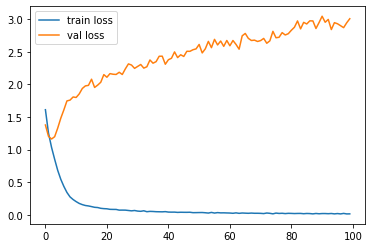

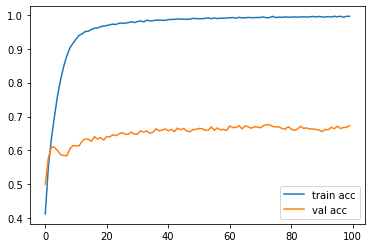

final test accuracy:  0.7176
final train accuracy:  0.9954
final val accuracy:  0.6734


<Figure size 432x288 with 0 Axes>

In [6]:
# finetune model
rn_backbone = ResNet18_backbone()
train_losses, train_accs, val_losses, val_accs, test_acc = ft_100e(rn_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])

We confirm that the model is overfitting the training data after a while. Next we want to investigate the effect of SSL. 

Understanding effect of optimizers and lr scheduler

Optimizer -> investigate use of SGD

In [3]:
ft_sgd = finetune(cifar10, 
                   num_epochs=100, 
                   verbose=True,
                   opt="SGD",
                   tensorboard_dir="/home/noah/ESSL/experiments/debugging/tensorboards/sgd")

In [4]:
rn_backbone = ResNet18_backbone()
train_losses, train_accs, val_losses, val_accs, test_acc = ft_sgd(rn_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])

 78%|███████████████████████████████████████           | 78/100 [26:22<07:26, 20.29s/it]


KeyboardInterrupt: 

In [ ]:
lr scheduler -> adam

In [ ]:
ft_adam_lrs = finetune(cifar10, 
                   num_epochs=100, 
                   verbose=True,
                   tensorboard_dir="/home/noah/ESSL/experiments/debugging/tensorboards/adam_lrs",
                   use_scheduler=True)

In [ ]:
rn_backbone = ResNet18_backbone()
train_losses, train_accs, val_losses, val_accs, test_acc = ft_adam_lrs(rn_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])

In [ ]:
lr scheduler -> SGD

In [ ]:
ft_sgd_lrs = finetune(cifar10, 
                   num_epochs=100, 
                   verbose=True,
                   opt="SGD",
                   tensorboard_dir="/home/noah/ESSL/experiments/debugging/tensorboards/SGD_lrs",
                   use_scheduler=True)

In [ ]:
rn_backbone = ResNet18_backbone()
train_losses, train_accs, val_losses, val_accs, test_acc = ft_sgd_lrs(rn_backbone, report_all_metrics=True)
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(train_accs, label = "train acc")
plt.plot(val_accs, label = "val acc")
plt.legend()
plt.show()
plt.clf()

print("final test accuracy: ", test_acc)
print("final train accuracy: ", train_accs[-1])
print("final val accuracy: ", val_accs[-1])